# Thyroid Classification Analysis

# Imports

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# Functions

In [157]:
def null_duplicate_check(df):
  print(f"Null Values Amount: {df.isna().sum()}")
  print(f"Duplicate Values Amount: {df.duplicated().sum()}")
  
def check_class_imbalance(target):
  
  target = np.array(target)
  
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 8))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Classes")
  plt.ylabel("Counts")
  plt.show()

def plot_model_performance(df, y, axis):
  
  fig, ax = plt.subplots(figsize=(15,8))
  df.plot.bar(x="Model",y=y, ax=ax)
  ax.set_xlabel("Model")
  ax.set_ylabel(axis)
  ax.set_title("Model Performance Comparison")
  
  ax.legend(y)
  ax.grid(True)
  plt.xticks(rotation=45)
  plt.show()

def create_confusion_matrix(model_name, y_test, y_test_pred, data_type):
  cm = confusion_matrix(y_test, y_test_pred)
  report = classification_report(y_test, y_test_pred)
  print(report)
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
  plt.title(f"Confusion Matrix for: {model_name}-{data_type}")
  plt.xlabel("True Labels")
  plt.ylabel("Predictions")
  plt.show()

def create_train_test_splits(X, y):
  
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
  
  return X_train, X_test, X_val, y_val, y_train, y_test
  

def create_column_transformer(numeric_features, categorical_features, ordinal_features):
  
  numeric_cols = numeric_features.columns
  categorical_cols = categorical_features.columns
  ordinal_cols = ordinal_features.columns
  
  numeric_transformer = Pipeline(
    steps=[ 
           ("scaler", StandardScaler()), 
           ("powertranformer", PowerTransformer())
           ]
  )
  
  categorical_tranformer = Pipeline(
    steps=[
      ("one_hot_encoder",OneHotEncoder())
    ]
  )
  
  ordinal_tranformer = Pipeline(
    steps=[
      ("ordinal", OrdinalEncoder())
    ]
  )
  
  preprocessor = ColumnTransformer(
    transformers=[
      ("num", numeric_transformer, numeric_cols),
      ("cat", categorical_tranformer, categorical_cols),
      ("ord", ordinal_tranformer, ordinal_cols)
    ]
  )
  
  return preprocessor

def create_pipeline(preprocessor, model, metric_name=None, kbest=None):
  steps = [("preprocessor", preprocessor), ("model", model)]
  
  if kbest:
    steps.insert(1, (metric_name, kbest))
  return Pipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sample, model):
  steps = [("preprocessor", preprocessor), ("sampled", sample), ("model", model)]
  
  return imbPipeline(steps)

def evaluate_model(X, y, model):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f1_score, average="micro")
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
  }
  
  return [models[model_name] for model_name in names]

def test_selected_models(preprocessor, models, model_names, X, y):
  
  model_performance = []
  
  for i in range(len(model_names)):
    model, model_name = models[i], model_names[i]
    pipeline = create_pipeline(preprocessor, model)
    scores = evaluate_model(X, y, pipeline)
    model_performance.append({
      "Model": model_name,
      "Mean": round(np.mean(scores),3),
      "STD":np.round(np.std(scores),3)
    })
  
  model_performance_df = pd.DataFrame(model_performance)
  model_performance_df = model_performance_df.sort_values(by="Mean", ascending=False)
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)
  
def get_over_sampling_methods(model_names):
  
  sampling_models = {
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(),
    "BL-SMOTE": BorderlineSMOTE(),
    "KNN-SMOTE": SMOTE(k_neighbors=5)
  }
  
  return [sampling_models[model_name] for model_name in model_names]

def test_sampled_selected_models(preprocessor, model_names, models, sampling_names, sampling_models, X, y):
  
  model_performance = []
  
  for idx in range(len(sampling_models)):
    sampling_name, sampling_model = sampling_names[idx], sampling_models[idx]
    for idx2 in range(len(models)):
      model_name, model = model_names[idx2], models[idx2]
      sampling_pipeline = create_sampling_pipeline(preprocessor, sampling_model, model)
      scores= evaluate_model(X,y,sampling_pipeline)
      model_performance.append({
      "Model": model_name + " " + sampling_name,
      "Mean": round(np.mean(scores),3),
      "STD":np.round(np.std(scores),3)
    })
  
  model_performance_df = pd.DataFrame(model_performance)
  model_performance_df = model_performance_df.sort_values(by="Mean", ascending =False).reset_index()
  plot_model_performance(model_performance_df, ["Mean", "STD"], "Mean")
  print(model_performance_df)

def test_predictions(preprocessor, model_names, models, X, y, sample_models=None, sampling_names=None):
  
  model_performance = []
  X_train, X_test, X_val, y_val, y_train, y_test = create_train_test_splits(X, y)
  
  for i in range(len(models)):
    model_name, model = model_names[i], models[i]
    
    if sample_models:
      model = create_sampling_pipeline(preprocessor, sample_models[i], model)
      sampling_model_name = sampling_names[i]
    else:
      model = create_pipeline(preprocessor, model)
    
    model.fit(X_train, y_train)
    
    y_pred_val = model.predict(X_val)
    y_val_acc = accuracy_score(y_val, y_pred_val)
    y_val_f1 = f1_score(y_val, y_pred_val)
    
    y_pred_test = model.predict(X_test)
    y_test_acc = accuracy_score(y_test, y_pred_test)
    y_test_f1 = f1_score(y_test, y_pred_test)
    
    create_confusion_matrix(model_name, y_test, y_pred_test, "Test Dataset")
    
    model_performance.append({
      "Model": model_name + " " + sampling_model_name if sample_models else "Model",
      "Test Accuracy": y_test_acc,
      "Validation Accuracy": y_val_acc,
      "Test-F1-Score": y_test_f1,
      "Val-F1-Score": y_val_f1,
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False).reset_index()
  print(model_performance_df)
  
def grid_search(models, model_names, params, X, y, metric):

  X_train, X_test, X_val, y_val, y_train, y_test = create_train_test_splits(X, y)
  
  model_performance = []
  for i in range(len(models)):
    model, model_name = models[i], model_names[i]
    grid_search = GridSearchCV(model, params[model_name], cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    print(f"The best params are: {grid_search.best_params_}")
    
    y_pred_val = best_model.predict(X_val)
    y_val_acc = accuracy_score(y_val, y_pred_val)
    y_val_f1 = f1_score(y_val, y_pred_val)
    
    y_pred_test = best_model.predict(X_test)
    y_test_acc = accuracy_score(y_test, y_pred_test)
    y_test_f1 = f1_score(y_test, y_pred_test)
    
    create_confusion_matrix(model_name, y_test, y_pred_test, "Test Dataset")
    
    model_performance.append({
      "Model":model_name,
      "Test Accuracy": y_test_acc,
      "Validation Accuracy": y_val_acc,
      "Test-F1-Score": y_test_f1,
      "Val-F1-Score": y_val_f1,
    })
  
  model_performance_df = pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False).reset_index()
  print(model_performance_df)

def pca_analysis(preprocessor, X):
  
  features= X.shape[1]
  results = []
  
  for n_components in range(1, features+1):
    pca = PCA(n_components=n_components)
    pipeline = create_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    
    explained_variance = np.sum(pca.explained_variance_ratio_)
    
    results.append({
      "Number of Components": n_components,
      "Cumulative Explained Variance": explained_variance
    })
  
  results_df = pd.DataFrame(results)
  return results_df

def test_kbest_columns(models, model_names, X, y, variance_window, metric):
  
  total_score, runs = 0,0
  model_performance = []
  
  for k in variance_window:
    fs = SelectKBest(score_func=metric, k=k)
    X_fs = fs.fit_transform(X, y)
    for i in range(len(models)):
      model, model_name = models[i], model_names[i]
      scores = evaluate_model(X_fs, y, model)
      mean_score = np.mean(scores)
      total_score += mean_score
      runs+=1
      model_performance.append({
        "Model": model_name,
        "Col #":k,
        "Mean": round(mean_score, 3),
        "STD": round(np.std(scores),3)
      })
  performance_df = pd.DataFrame(model_performance).sort_values(by="Mean", ascending=False)
  print(f"Average total Score: {total_score/runs}")
  plot_model_performance(performance_df, ["Mean", "STD"], "Mean")
  print(performance_df)

# EDA Analysis

In [88]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,72,M,Yes,Yes,Yes,Euthyroid,Single nodular goiter-right,Right,Papillary,Uni-Focal,High,T4b,N1b,M1,IVB,Biochemical Incomplete,Yes
379,81,M,Yes,No,Yes,Euthyroid,Multinodular goiter,Extensive,Papillary,Multi-Focal,High,T4b,N1b,M1,IVB,Structural Incomplete,Yes
380,72,M,Yes,Yes,No,Euthyroid,Multinodular goiter,Bilateral,Papillary,Multi-Focal,High,T4b,N1b,M1,IVB,Structural Incomplete,Yes
381,61,M,Yes,Yes,Yes,Clinical Hyperthyroidism,Multinodular goiter,Extensive,Hurthel cell,Multi-Focal,High,T4b,N1b,M0,IVA,Structural Incomplete,Yes


# Check for Nulls and Dupes

In [89]:
null_duplicate_check(df)

Null Values Amount: Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
Recurred                0
dtype: int64
Duplicate Values Amount: 19


In [90]:
df.drop_duplicates(inplace=True)

# Check for class imbalance

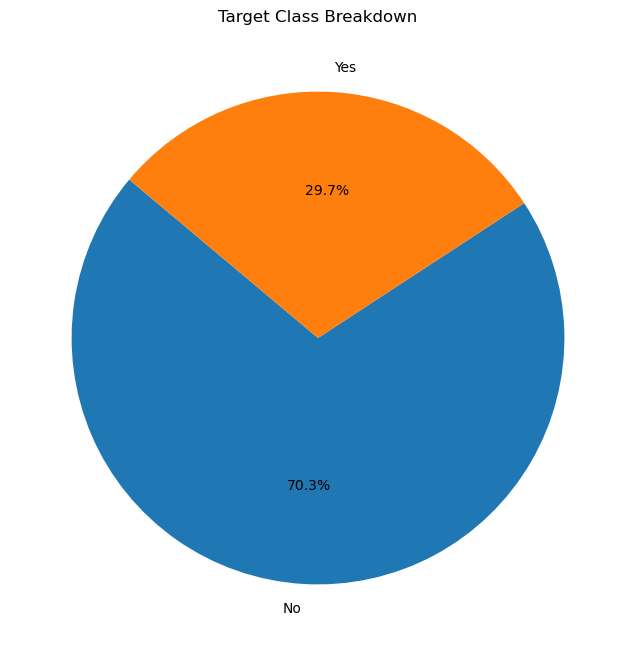

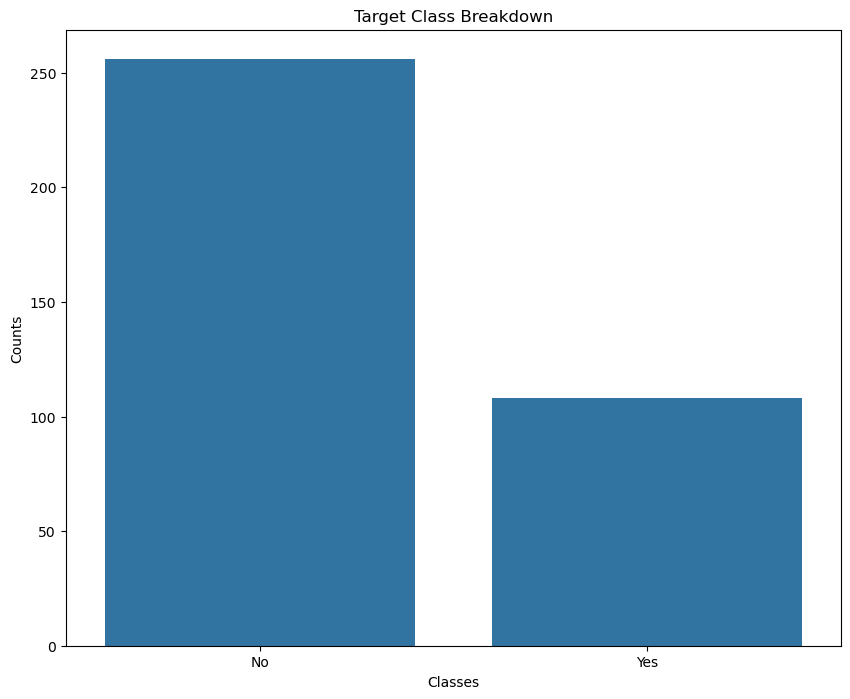

In [91]:
check_class_imbalance(df["Recurred"])

# Classes are imbalanced which means we will have to use some sampling techniques in order to address the imabalance

In [92]:
df.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

# All but one column is an integer value which means, we will have to do some preprocessing in order to format the data on our models.

In [93]:
categorical_features, numeric_features = df.select_dtypes(include=["object"]).drop("Recurred", axis=1), df.select_dtypes(include="int64")

# We have ordinal columns and we also have catergorical columns, we need to address this in our processing stages. The only issue is that I don't know which columns are categorical and ordinal. We will have to guess.

In [94]:
ordinal_features = categorical_features[["Stage", "Response", "Risk"]]

In [95]:
categorical_features.drop(["Stage", "Response", "Risk"], axis=1, inplace=True)

# Create Column Transformer

In [96]:
preprocessor = create_column_transformer(numeric_features, categorical_features, ordinal_features)

# Separate Feature columns

In [97]:
X, y = df.drop("Recurred", axis=1), df["Recurred"]

# Label encode Target Class

In [98]:
encoder = LabelEncoder()

y = encoder.fit_transform(y)

# We will score our models based on F1 Score giving equal balance to both classes given this is a serious health condition

# Baseline Model

In [99]:
model = DummyClassifier(strategy="constant", constant=1)
pipeline = create_pipeline(preprocessor, model)
scores = evaluate_model(X, y, pipeline)

scores = evaluate_model(X, y, pipeline)
print(f"Mean: {round(np.mean(scores),3)}, STD: {round(np.std(scores),3)}")

Mean: 0.297, STD: 0.01


# Advanced Model Metrics

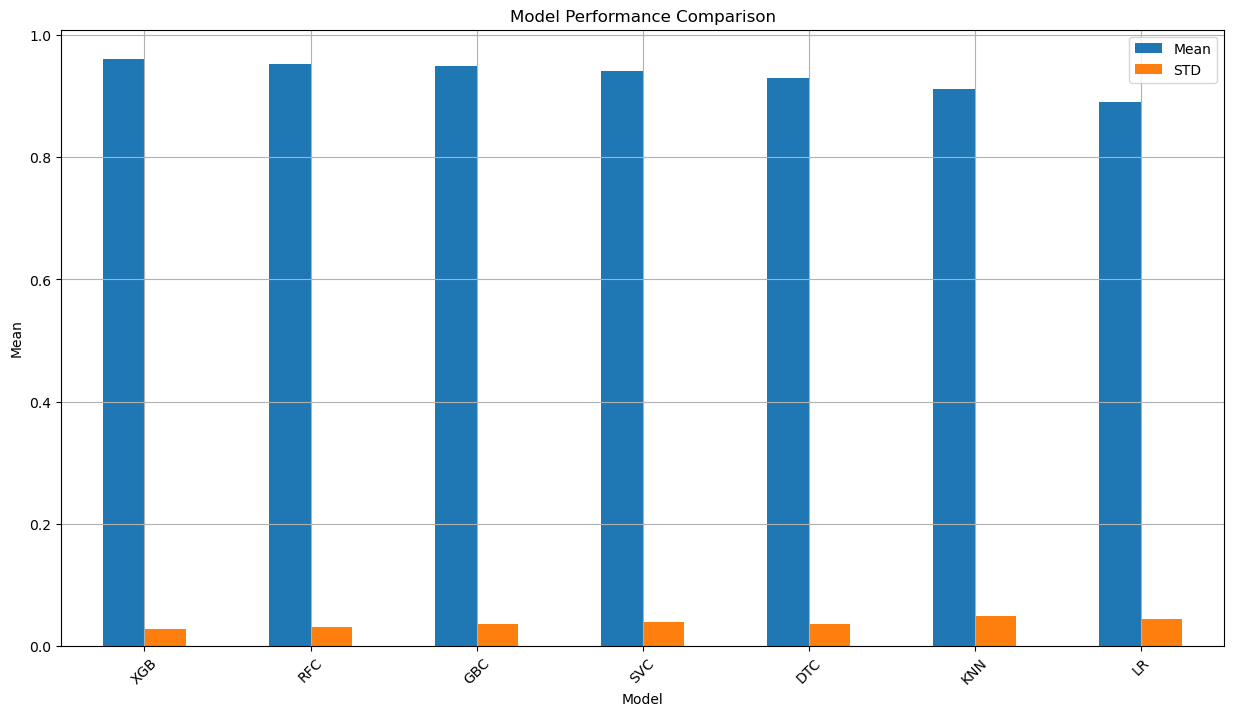

  Model   Mean    STD
5   XGB  0.961  0.028
3   RFC  0.953  0.030
4   GBC  0.950  0.035
2   SVC  0.941  0.038
6   DTC  0.930  0.036
0   KNN  0.912  0.048
1    LR  0.891  0.044


In [100]:
model_names = ["KNN", "LR", "SVC", "RFC", "GBC", "XGB", "DTC"]
models = grab_selected_models(model_names)
test_selected_models(preprocessor, models, model_names, X, y)

# We have acheived some high scores, however, our data is imbalanced so these scores could be considered irrelevant. We will have to test out over sampling methods and see which methods work the best. Let's see how our models performs on testing and validation datasets.

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.91      0.95        11

    accuracy                           0.97        37
   macro avg       0.98      0.95      0.97        37
weighted avg       0.97      0.97      0.97        37



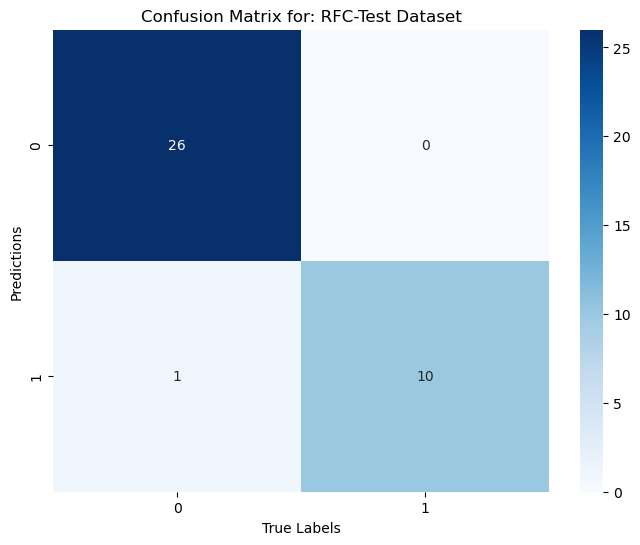

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.79      1.00      0.88        11

    accuracy                           0.92        37
   macro avg       0.89      0.94      0.91        37
weighted avg       0.94      0.92      0.92        37



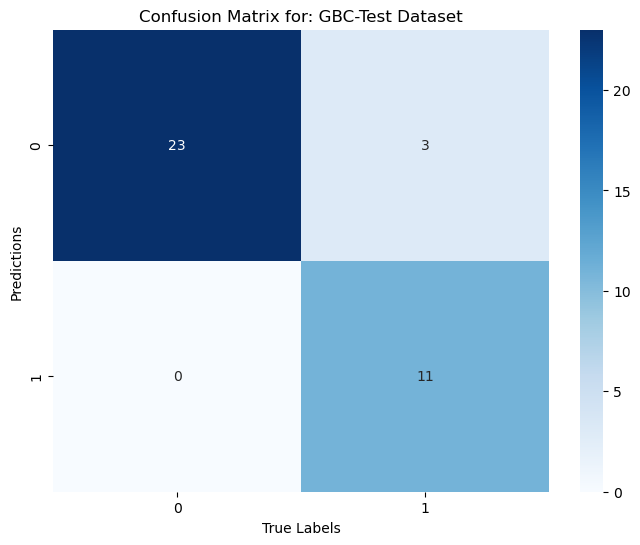

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.85      1.00      0.92        11

    accuracy                           0.95        37
   macro avg       0.92      0.96      0.94        37
weighted avg       0.95      0.95      0.95        37



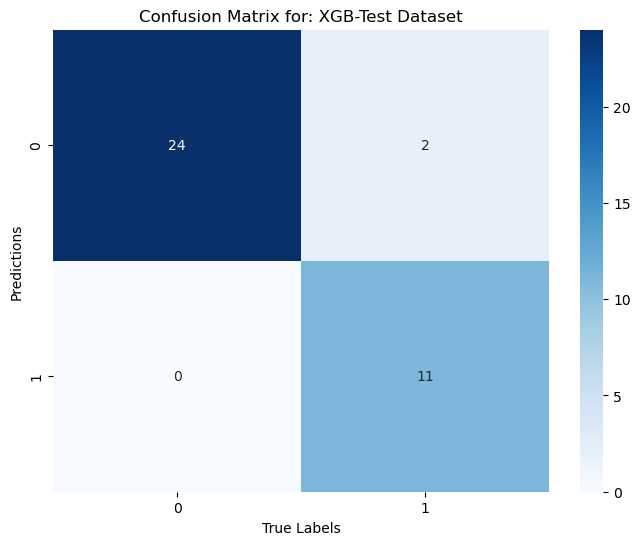

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.85      1.00      0.92        11

    accuracy                           0.95        37
   macro avg       0.92      0.96      0.94        37
weighted avg       0.95      0.95      0.95        37



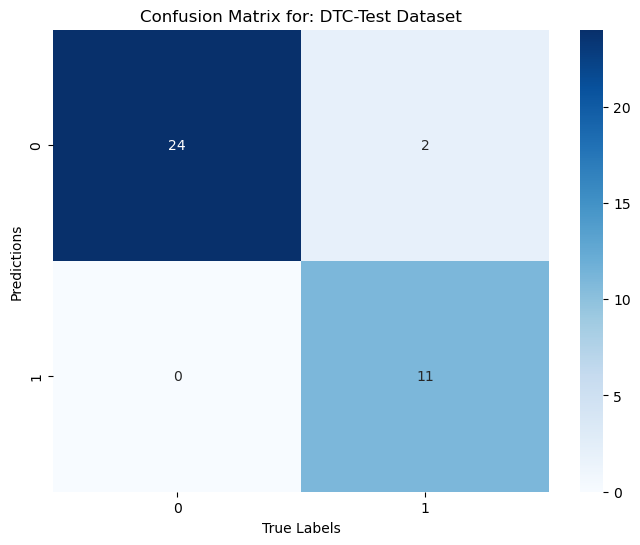

   index  Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      0  Model       0.972973             0.916667       0.952381   
1      2  Model       0.945946             0.944444       0.916667   
2      3  Model       0.945946             0.916667       0.916667   
3      1  Model       0.918919             0.944444       0.880000   

   Val-F1-Score  
0      0.869565  
1      0.909091  
2      0.869565  
3      0.909091  


In [101]:
model_names = ["RFC", "GBC", "XGB", "DTC"]
models = grab_selected_models(model_names)

test_predictions(preprocessor, model_names, models, X, y)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        26
           1       0.73      0.73      0.73        11

    accuracy                           0.84        37
   macro avg       0.81      0.81      0.81        37
weighted avg       0.84      0.84      0.84        37



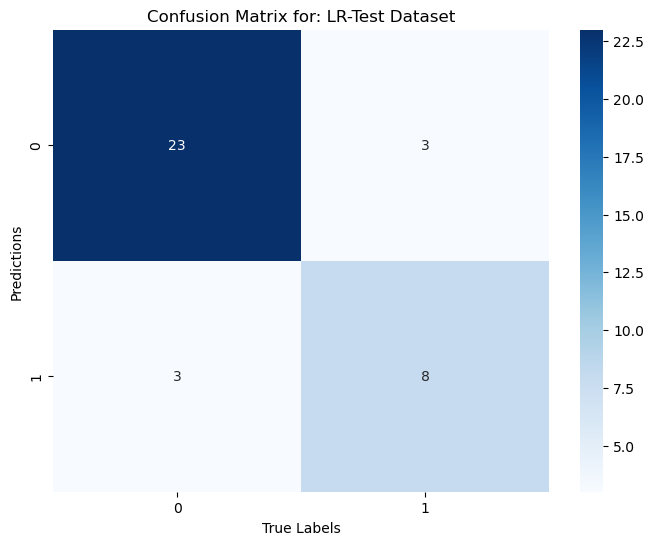

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.91      0.91      0.91        11

    accuracy                           0.95        37
   macro avg       0.94      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



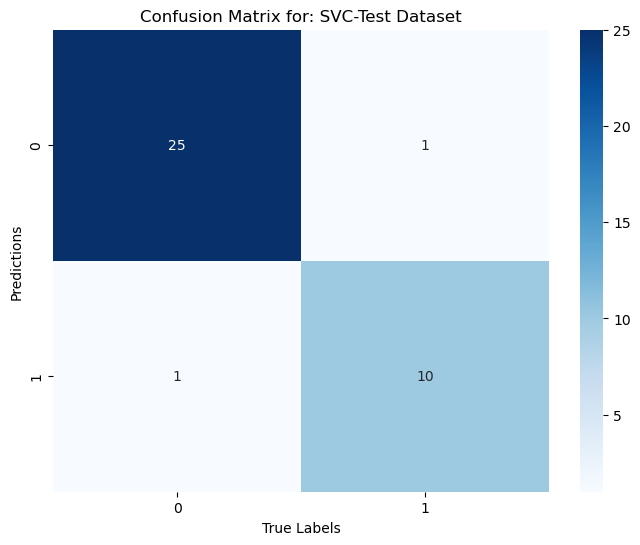

              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.89      0.73      0.80        11

    accuracy                           0.89        37
   macro avg       0.89      0.84      0.86        37
weighted avg       0.89      0.89      0.89        37



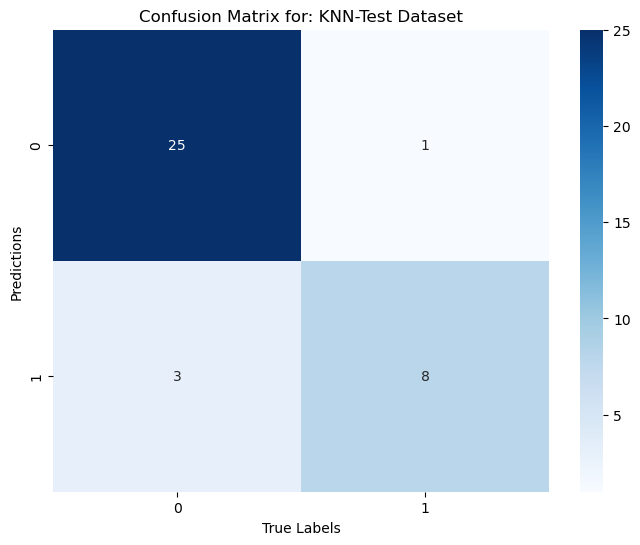

   index  Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      1  Model       0.945946             0.888889       0.909091   
1      2  Model       0.891892             0.888889       0.800000   
2      0  Model       0.837838             0.916667       0.727273   

   Val-F1-Score  
0      0.818182  
1      0.800000  
2      0.857143  


In [102]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)

test_predictions(preprocessor, model_names, models, X, y)

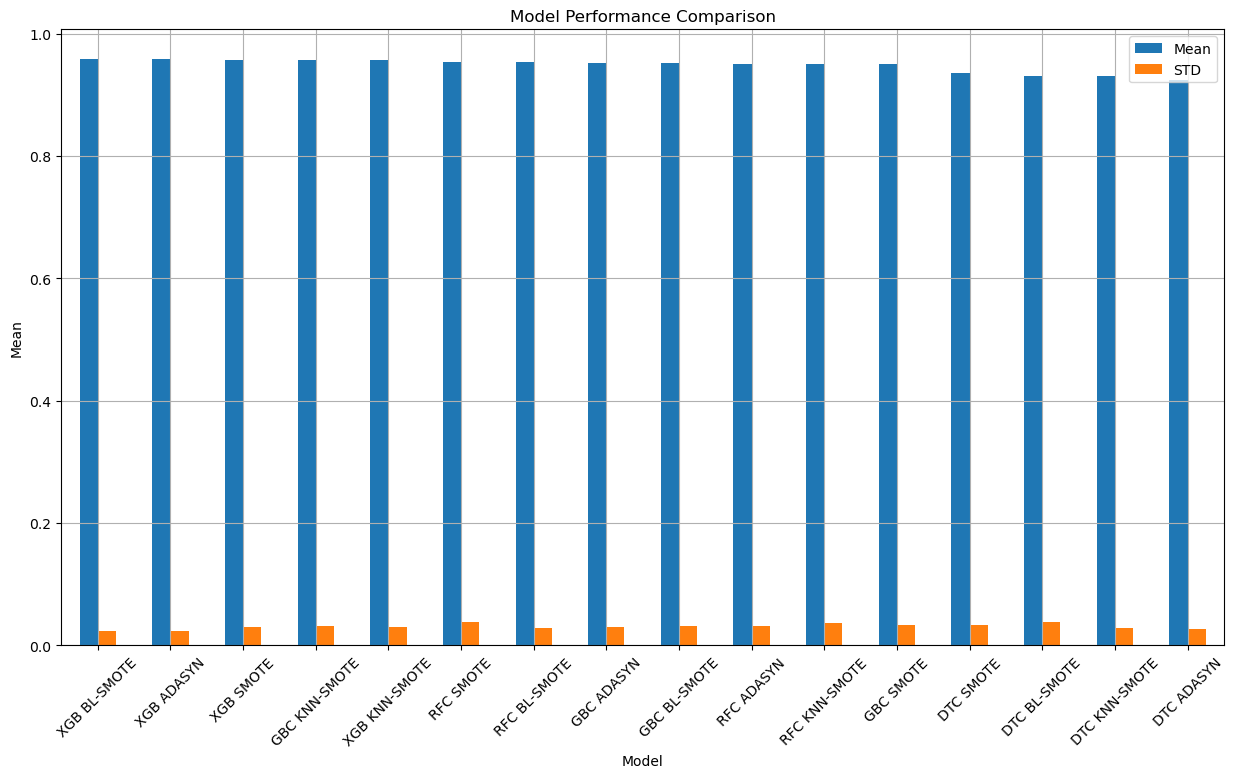

    index          Model   Mean    STD
0      11   XGB BL-SMOTE  0.959  0.023
1       7     XGB ADASYN  0.958  0.023
2       3      XGB SMOTE  0.957  0.030
3      14  GBC KNN-SMOTE  0.957  0.032
4      15  XGB KNN-SMOTE  0.957  0.030
5       0      RFC SMOTE  0.954  0.038
6       8   RFC BL-SMOTE  0.953  0.029
7       6     GBC ADASYN  0.952  0.030
8      10   GBC BL-SMOTE  0.952  0.032
9       4     RFC ADASYN  0.951  0.031
10     12  RFC KNN-SMOTE  0.951  0.037
11      2      GBC SMOTE  0.950  0.034
12      1      DTC SMOTE  0.936  0.034
13      9   DTC BL-SMOTE  0.931  0.039
14     13  DTC KNN-SMOTE  0.931  0.029
15      5     DTC ADASYN  0.924  0.027


In [103]:
sampling_names=["SMOTE", "ADASYN", "BL-SMOTE", "KNN-SMOTE"]
model_names = ["RFC", "DTC", "GBC", "XGB"]
models = grab_selected_models(model_names)
sampling_models = get_over_sampling_methods(sampling_names)

test_sampled_selected_models(preprocessor, model_names, models, sampling_names, sampling_models, X, y)

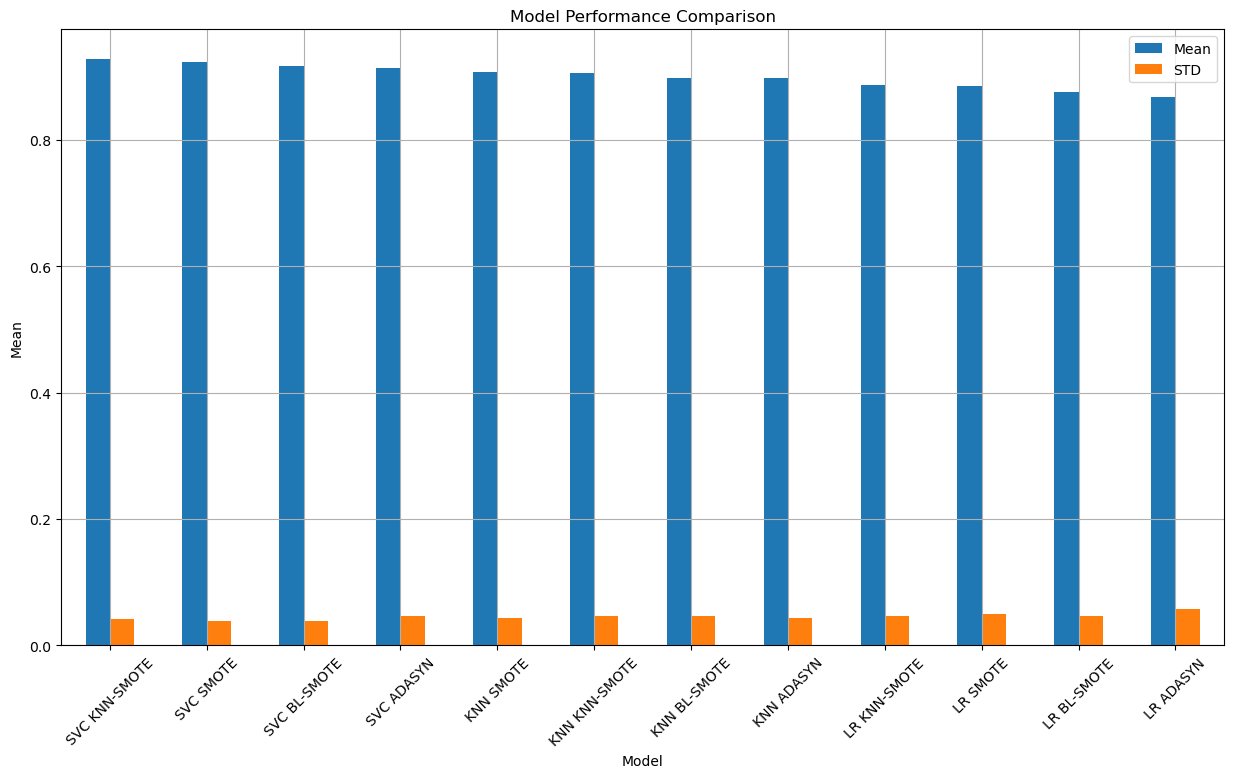

    index          Model   Mean    STD
0      10  SVC KNN-SMOTE  0.928  0.042
1       1      SVC SMOTE  0.923  0.038
2       7   SVC BL-SMOTE  0.916  0.038
3       4     SVC ADASYN  0.914  0.046
4       2      KNN SMOTE  0.907  0.043
5      11  KNN KNN-SMOTE  0.906  0.046
6       8   KNN BL-SMOTE  0.898  0.046
7       5     KNN ADASYN  0.897  0.043
8       9   LR KNN-SMOTE  0.886  0.047
9       0       LR SMOTE  0.885  0.050
10      6    LR BL-SMOTE  0.876  0.047
11      3      LR ADASYN  0.867  0.057


In [104]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
test_sampled_selected_models(preprocessor, model_names, models, sampling_names, sampling_models, X, y)

# Lets Test predictions on our best models

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.79      1.00      0.88        11

    accuracy                           0.92        37
   macro avg       0.89      0.94      0.91        37
weighted avg       0.94      0.92      0.92        37



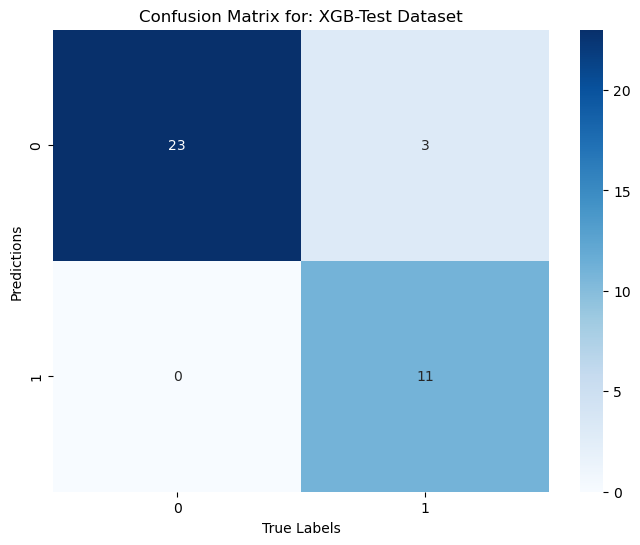

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.92      1.00      0.96        11

    accuracy                           0.97        37
   macro avg       0.96      0.98      0.97        37
weighted avg       0.98      0.97      0.97        37



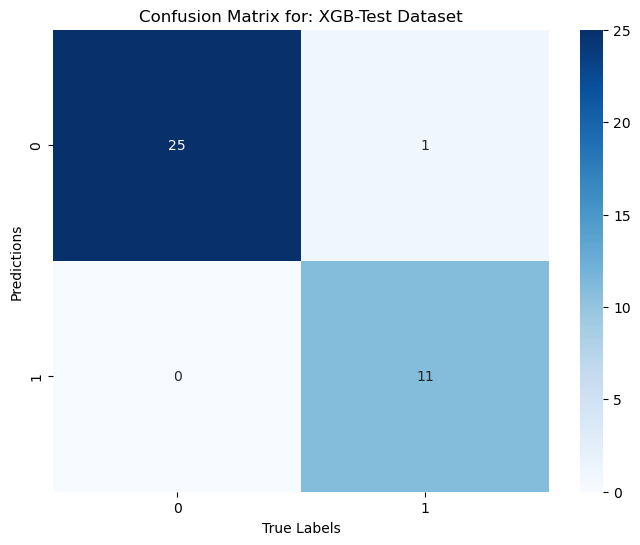

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.85      1.00      0.92        11

    accuracy                           0.95        37
   macro avg       0.92      0.96      0.94        37
weighted avg       0.95      0.95      0.95        37



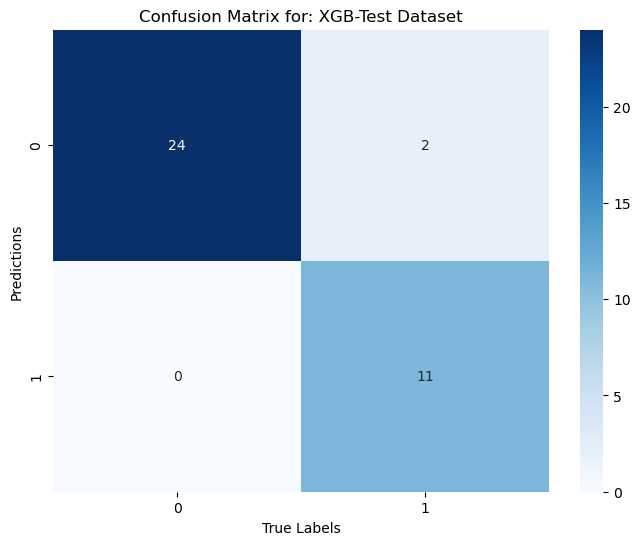

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.85      1.00      0.92        11

    accuracy                           0.95        37
   macro avg       0.92      0.96      0.94        37
weighted avg       0.95      0.95      0.95        37



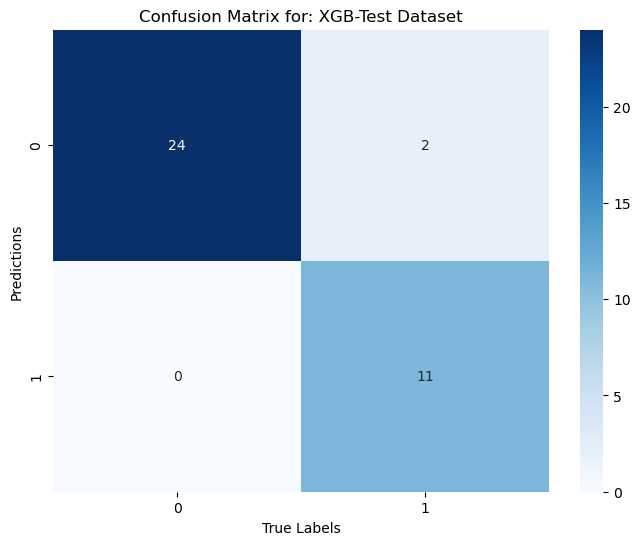

   index          Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      1     XGB ADASYN       0.972973             0.944444       0.956522   
1      2   XGB BL-SMOTE       0.945946             0.944444       0.916667   
2      3      XGB SMOTE       0.945946             0.916667       0.916667   
3      0  XGB KNN-SMOTE       0.918919             0.944444       0.880000   

   Val-F1-Score  
0      0.909091  
1      0.909091  
2      0.869565  
3      0.909091  


In [121]:
model_names = ["XGB", "XGB", "XGB", "XGB"]
models = grab_selected_models(model_names)
sampling_names = ["KNN-SMOTE", "ADASYN", "BL-SMOTE", "SMOTE"]
sample_models = get_over_sampling_methods(sampling_names)

test_predictions(preprocessor, model_names, models, X, y,sample_models=sample_models, sampling_names=sampling_names)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.83      0.91      0.87        11

    accuracy                           0.92        37
   macro avg       0.90      0.92      0.91        37
weighted avg       0.92      0.92      0.92        37



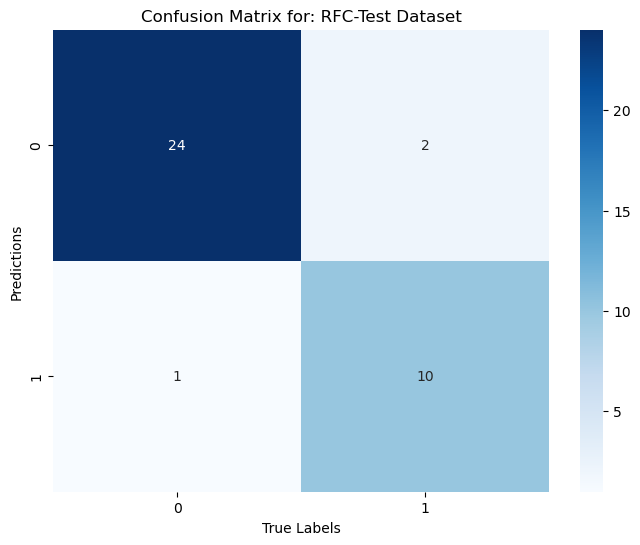

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.83      0.91      0.87        11

    accuracy                           0.92        37
   macro avg       0.90      0.92      0.91        37
weighted avg       0.92      0.92      0.92        37



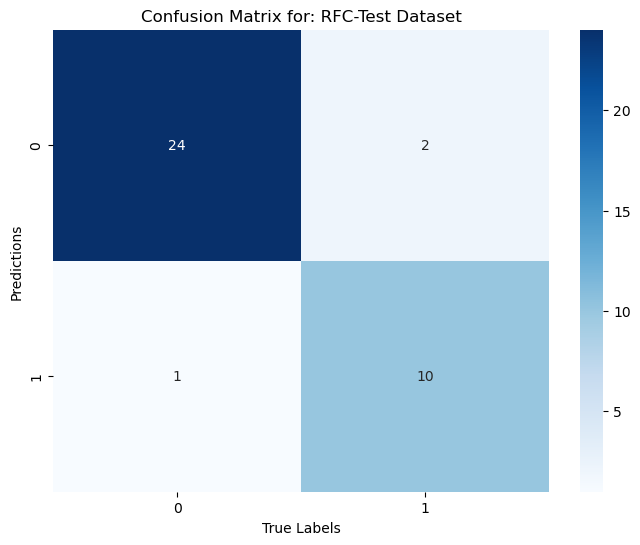

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.91      0.91      0.91        11

    accuracy                           0.95        37
   macro avg       0.94      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



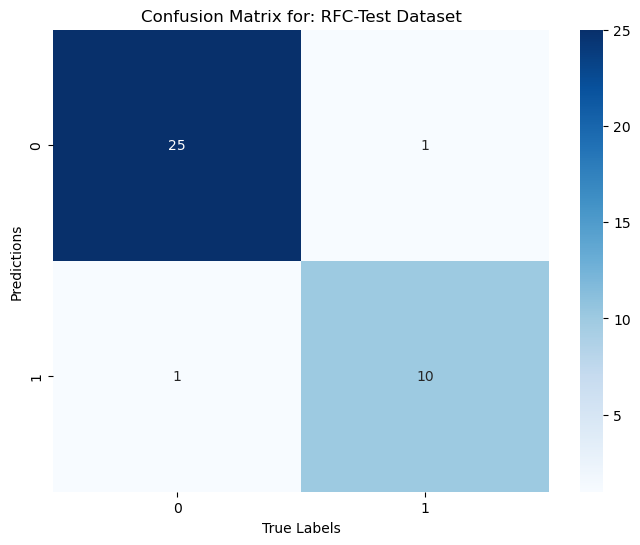

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        26
           1       0.91      0.91      0.91        11

    accuracy                           0.95        37
   macro avg       0.94      0.94      0.94        37
weighted avg       0.95      0.95      0.95        37



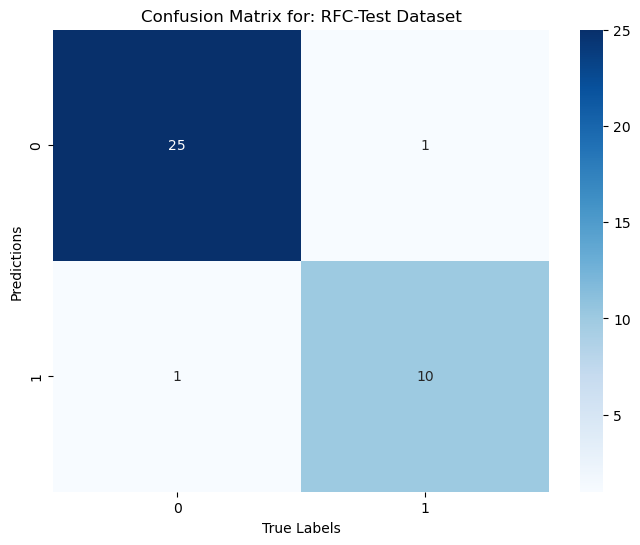

   index          Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      2   RFC BL-SMOTE       0.945946             0.888889       0.909091   
1      3      RFC SMOTE       0.945946             0.888889       0.909091   
2      0  RFC KNN-SMOTE       0.918919             0.888889       0.869565   
3      1     RFC ADASYN       0.918919             0.888889       0.869565   

   Val-F1-Score  
0      0.833333  
1      0.833333  
2      0.818182  
3      0.833333  


In [143]:
model_names = ["RFC", "RFC", "RFC", "RFC"]
models = grab_selected_models(model_names)
sampling_names = ["KNN-SMOTE", "ADASYN", "BL-SMOTE", "SMOTE"]
sample_models = get_over_sampling_methods(sampling_names)

test_predictions(preprocessor, model_names, models, X, y,sample_models=sample_models, sampling_names=sampling_names)

# XGB has the best model performance by far

# Since we have a very small dataset, its likely that our model is overfitting. We should implement regularization methods in order to prevent our model from overfitting when we create the final model.

# Hyperparameter Tuning

# Fit Resampling method given that you must resample before using grid search. The pipeline will be unable to convert certain columns

In [128]:
sampling_model = get_over_sampling_methods(["ADASYN"])[0]
model = grab_selected_models(["XGB"])
X_processed = preprocessor.fit_transform(X)

In [130]:
X_resampled, Y_resampled = sampling_model.fit_resample(X_processed, y)

# Now I can pass this into our grid search function and find the best parameters for the best results

The best params are: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.92      0.96      0.94        25

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51



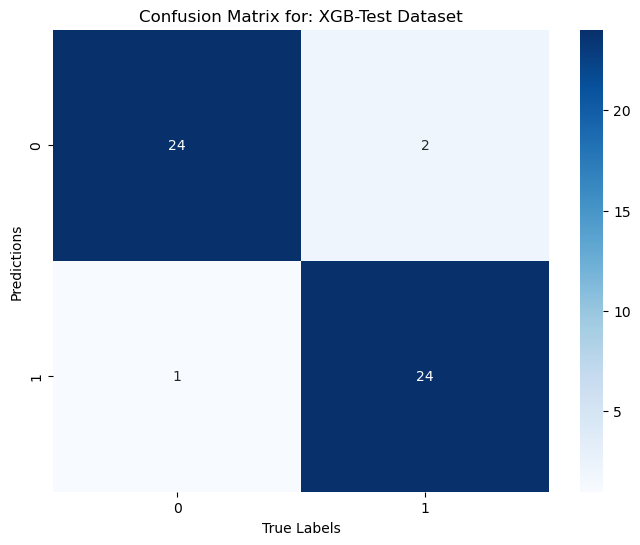

The best params are: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.92      0.96      0.94        25

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51



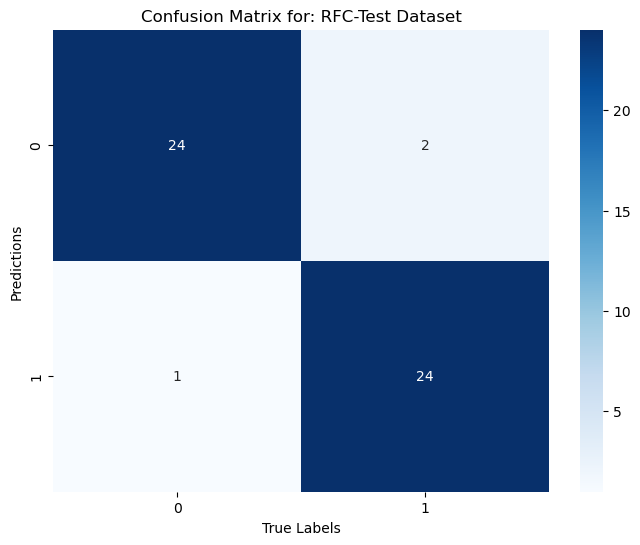

   index Model  Test Accuracy  Validation Accuracy  Test-F1-Score  \
0      0   XGB       0.941176             0.941176       0.941176   
1      1   RFC       0.941176             0.921569       0.941176   

   Val-F1-Score  
0      0.941176  
1      0.923077  


In [144]:
params = {
  "XGB":{
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
  
},
  "RFC":{
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
  }
  }

model_names = ["XGB", "RFC"]
models = grab_selected_models(model_names)
metric = make_scorer(f1_score)

grid_search(models, model_names, params, X_resampled, Y_resampled, metric)

# Validation and Testing scores for F1-Score is over 94%.

# Lets Do a PCA Analysis to reduce feature dimesionality

In [141]:
pca_analysis(preprocessor, X)

,Number of Components,Cumulative Explained Variance
0,1,0.287268
1,2,0.431921
2,3,0.498545
3,4,0.560534
4,5,0.617522
5,6,0.665855
6,7,0.708357
7,8,0.748993
8,9,0.784802
9,10,0.811745


# 70 - 90% of our data is between 7-16 columns, this means there is room for feature dimensionality reduction

# Let's test for the kbest columns using F-Stat

Average total Score: 0.9552104575163399


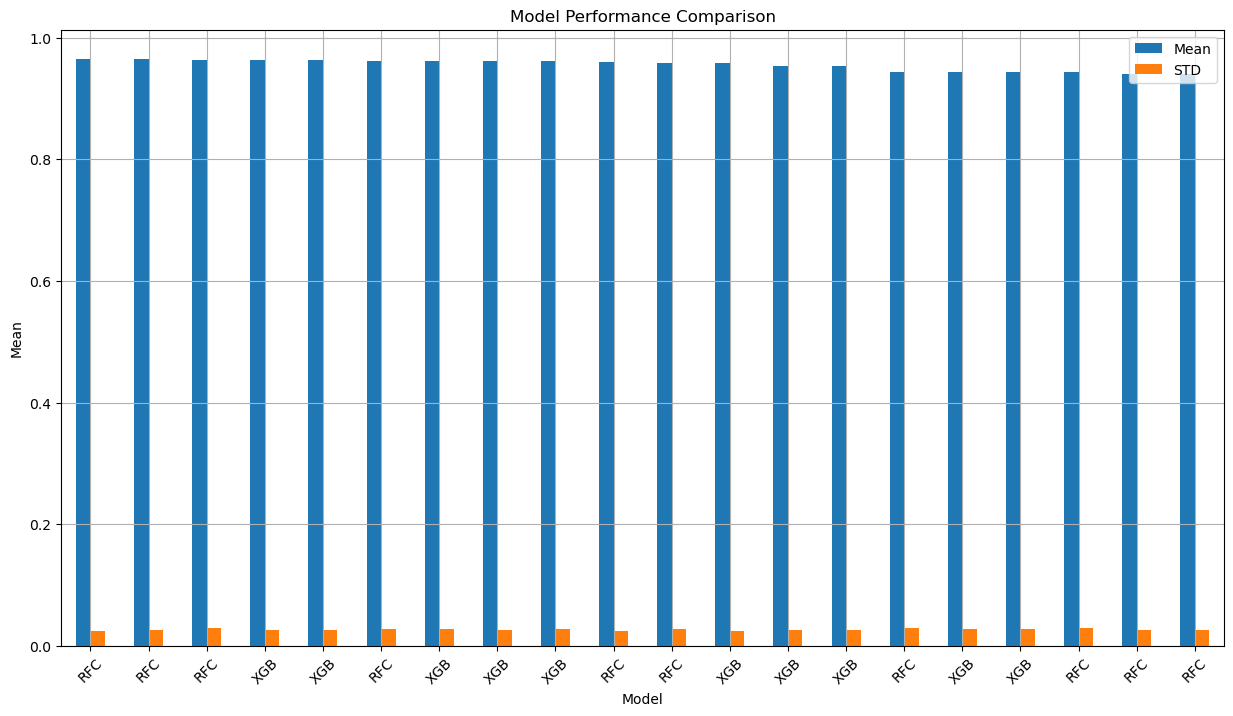

   Model  Col #   Mean    STD
19   RFC     16  0.965  0.024
13   RFC     13  0.965  0.025
15   RFC     14  0.964  0.029
14   XGB     14  0.963  0.025
12   XGB     13  0.963  0.025
17   RFC     15  0.962  0.027
8    XGB     11  0.961  0.027
18   XGB     16  0.961  0.026
10   XGB     12  0.961  0.027
11   RFC     12  0.960  0.024
9    RFC     11  0.959  0.027
16   XGB     15  0.959  0.024
2    XGB      8  0.953  0.026
0    XGB      7  0.953  0.026
1    RFC      7  0.944  0.029
6    XGB     10  0.944  0.028
4    XGB      9  0.944  0.027
3    RFC      8  0.943  0.029
7    RFC     10  0.941  0.025
5    RFC      9  0.940  0.025


In [158]:
models = [
  XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators= 200),
  RandomForestClassifier(max_depth=30, min_samples_leaf= 1, min_samples_split=2, n_estimators=200)
]
model_names = ["XGB", "RFC"]
variance_window = range(7, 16+1)
metric=f_classif
test_kbest_columns(models, model_names, X_resampled, Y_resampled, variance_window, metric)

# Mutual Info Test

Average total Score: 0.9649333333333334


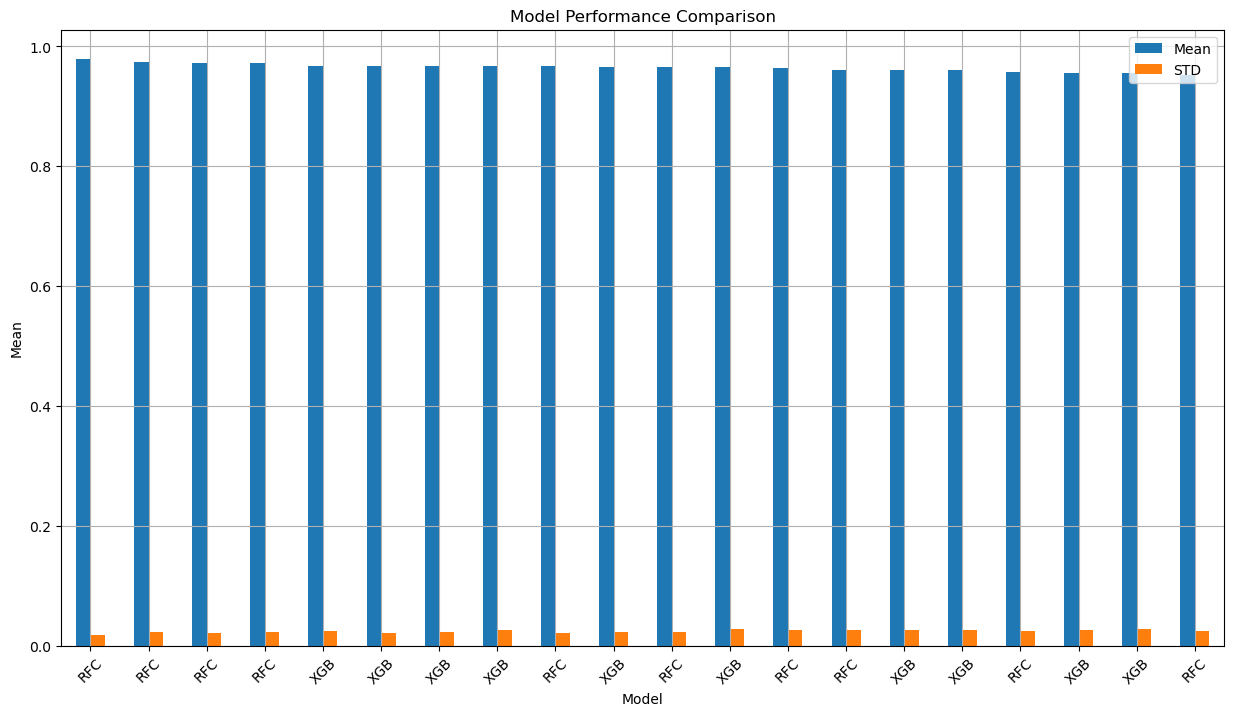

   Model  Col #   Mean    STD
3    RFC      8  0.979  0.018
15   RFC     14  0.974  0.023
13   RFC     13  0.973  0.021
17   RFC     15  0.972  0.023
10   XGB     12  0.968  0.024
16   XGB     15  0.968  0.022
12   XGB     13  0.967  0.023
2    XGB      8  0.967  0.026
7    RFC     10  0.967  0.022
14   XGB     14  0.966  0.023
19   RFC     16  0.966  0.023
18   XGB     16  0.965  0.028
11   RFC     12  0.964  0.027
9    RFC     11  0.961  0.027
8    XGB     11  0.961  0.026
6    XGB     10  0.960  0.026
5    RFC      9  0.957  0.025
0    XGB      7  0.956  0.027
4    XGB      9  0.955  0.028
1    RFC      7  0.953  0.024


In [159]:
models = [
  XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators= 200),
  RandomForestClassifier(max_depth=30, min_samples_leaf= 1, min_samples_split=2, n_estimators=200)
]
model_names = ["XGB", "RFC"]
variance_window = range(7, 16+1)
metric=mutual_info_classif
test_kbest_columns(models, model_names, X_resampled, Y_resampled, variance_window, metric)

# We may be able to cut down our feature dimensionality in half